# Задание 1
1) На одной из задач сравните, что лучше: а) конкатенировать эмбединги в один большой эмбединг, б) усреднять эмбединги, в) складывать эмбединги. 
Зафиксируйте разбиение на train_test  через random_seed, чтобы обучаться и оцениваться на одних и тех же данных. 
Параметры нейронок не нужно делать одинаковыми. Просто попробуйте добиться максимума от каждого из подходов. 

Возьмем вторую задачу - **классификацию**

In [21]:
from collections import Counter
import pandas as pd
import numpy as np
from string import punctuation

import gensim
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
filepath = "data/quora.csv"

MAX_LEN = 100
RANDOM_SEED = 23
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
quora = pd.read_csv(filepath)
print(quora.shape)
quora.head()

(1306122, 3)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [9]:
quora.target.value_counts(normalize=True)

0    0.93813
1    0.06187
Name: target, dtype: float64

Есть дизбаланс классов, поэтому итоговую метрику для сравнения буду брать F1-score

In [10]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [11]:
# Словарь
vocab = Counter()
for text in quora.question_text:
    vocab.update(preprocess(text))

# отфильтрованный словарь
filtered_vocab = set()
for word in vocab:
    if vocab[word] > 50:
        filtered_vocab.add(word)

print(f"Initial Vocab: {len(vocab)}\nFiltered Vocab: {len(filtered_vocab)}")

# индексируем слова
word2id = {'PAD':0}
for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

Initial Vocab: 273056
Filtered Vocab: 14083


In [12]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, dataset, word2id, MAX_LEN, text_field, target_field):
        
        self.dataset = dataset[text_field].values
        
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset[target_field].values)

    def __len__(self):
        return self.length

    def __getitem__(self, index):

        tokens = self.preprocess(self.dataset[index])
        ids = [self.word2id[token] for token in tokens if token in self.word2id][:MAX_LEN]
        ids = torch.nn.functional.pad(torch.LongTensor(ids), 
                                (0, self.MAX_LEN-len(ids)), 
                                mode='constant',
                                value=0)
        y = self.target[index]
        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [14]:
train_dataset, valid_dataset = train_test_split(quora, test_size=0.05, random_state=RANDOM_SEED, stratify=quora.target)

training_set = Dataset(train_dataset, word2id, MAX_LEN, 'question_text', 'target')
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256)

valid_set = Dataset(valid_dataset, word2id, MAX_LEN, 'question_text', 'target')
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256)
print(len(train_dataset), len(valid_dataset))

1240815 65307


In [15]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc


def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()  
        loss = criterion(predictions.float(), ys.to(device).float())        
        acc = binary_accuracy(predictions.float(), ys.to(device).float())
        loss.backward()     
        
        optimizer.step()      
        epoch_loss += loss.item()  
        epoch_acc += acc.item()
        
        if not (i+1) % print_every:
            print(f'Loss: {epoch_loss/i}; Accuracy: {epoch_acc/i}')
        
    return epoch_acc / len(iterator)


def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.float(), ys.to(device).float())        
            acc = binary_accuracy(predictions.float(), ys.to(device).float())

            epoch_loss += loss.item()  
            epoch_acc += acc.item()
            
    return epoch_acc / len(iterator)

## а) конкатенировать эмбединги в один большой эмбединг

Здесь и далее я сохраняю вывод наилучшей модели, после подбора гиперпараметров. Их тут немного, буду подбирать embedding_dim, порог для принадлежности к положительному классу и кол-во эпох обучения. 

In [105]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.flatten = nn.Flatten() # вместо усреднения склеим все в 1 вектор
        self.fc = nn.Linear(embedding_dim*MAX_LEN, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        hidden = self.flatten(embedded)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        
        return outputs

In [106]:
model = Clf(len(word2id), embedding_dim=30, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [107]:
accs = []
accs_eval = []
for i in range(5):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.18275465654419945; Accuracy: 0.9404795420420421
Loss: 0.16681675766485224; Accuracy: 0.9432587387443722
Loss: 0.15767654732848532; Accuracy: 0.9450129209736579
Loss: 0.15144529885878621; Accuracy: 0.9463684280445112
1
Loss: 0.1266122884802274; Accuracy: 0.952784816066066
Loss: 0.12525039406613506; Accuracy: 0.9528436093046523
Loss: 0.12436328915287233; Accuracy: 0.9529009669889963
Loss: 0.12348768593769993; Accuracy: 0.9531240231932984
2
Loss: 0.11962578962515066; Accuracy: 0.9550448886386387
Loss: 0.11897834715409658; Accuracy: 0.9548446098049025
Loss: 0.11864888298139846; Accuracy: 0.9547635670223408
Loss: 0.1181457963545983; Accuracy: 0.954867623155789
3
Loss: 0.11617141557079894; Accuracy: 0.9562492179679679
Loss: 0.11591942500455371; Accuracy: 0.9559897136068034
Loss: 0.11587926847024853; Accuracy: 0.9557534803267755
Loss: 0.11543331733641847; Accuracy: 0.9558385690172543
4
Loss: 0.1141076395633044; Accuracy: 0.957152464964965
Loss: 0.11398032586975; Accuracy: 0.95674204

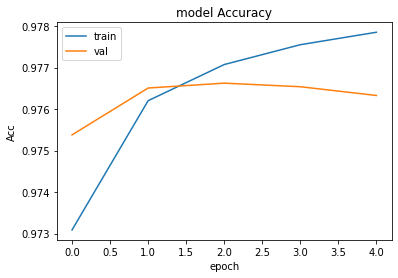

In [108]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [109]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [111]:
print(classification_report(targets, (np.array(preds) > 0.3).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61266
         1.0       0.60      0.62      0.61      4041

    accuracy                           0.95     65307
   macro avg       0.79      0.80      0.79     65307
weighted avg       0.95      0.95      0.95     65307



## б) усреднять эмбединги,

In [112]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        embedded_mean = torch.mean(embedded, dim=1)
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [113]:
model = Clf(len(word2id), embedding_dim=60, output_dim=1)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [114]:
accs = []
accs_eval = []
for i in range(10):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.2761245961184497; Accuracy: 0.9387160598098098
Loss: 0.25020107749165627; Accuracy: 0.9384086574537268
Loss: 0.2411269984565484; Accuracy: 0.9383505439313105
Loss: 0.23607930241263966; Accuracy: 0.9384172214928732
1
Loss: 0.22074392188836386; Accuracy: 0.9387160598098098
Loss: 0.21936323289471069; Accuracy: 0.9384086574537268
Loss: 0.21804015514313202; Accuracy: 0.9383505439313105
Loss: 0.21642805854099398; Accuracy: 0.9384172214928732
2
Loss: 0.20767510096888403; Accuracy: 0.9387238801301301
Loss: 0.205352380465513; Accuracy: 0.938422336168084
Loss: 0.2032298174857219; Accuracy: 0.9383987370790263
Loss: 0.20087504095138684; Accuracy: 0.9385041572893223
3
Loss: 0.18856761966262375; Accuracy: 0.9395919356856857
Loss: 0.18623165827637736; Accuracy: 0.9394619184592297
Loss: 0.18429084721904232; Accuracy: 0.9395762129043015
Loss: 0.1821542469787878; Accuracy: 0.9398531273443361
4
Loss: 0.17244230569512756; Accuracy: 0.9415431056056056
Loss: 0.1707514642424259; Accuracy: 0.9413359

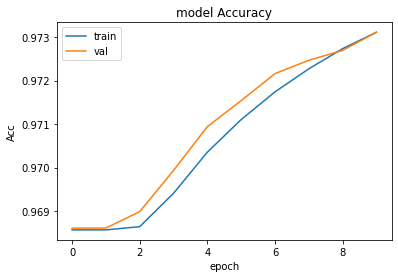

In [115]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [116]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [121]:
print(classification_report(targets, (np.array(preds) > 0.2).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97     61266
         1.0       0.49      0.60      0.54      4041

    accuracy                           0.94     65307
   macro avg       0.73      0.78      0.75     65307
weighted avg       0.94      0.94      0.94     65307



## в) складывать эмбединги

In [122]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_dim):
        
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim) # размер склееного вектора - размер эмбединга на MAX_LEN
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded = self.embedding(text)   
        embedded_mean = torch.sum(embedded, dim=1)
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [123]:
model = Clf(len(word2id), embedding_dim=50, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [124]:
accs = []
accs_eval = []
for i in range(10):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.20311971637490275; Accuracy: 0.9375938438438438
Loss: 0.1782516239731833; Accuracy: 0.94193971985993
Loss: 0.16654895904134534; Accuracy: 0.9441532594198067
Loss: 0.1589453240731234; Accuracy: 0.9456504751187796
1
Loss: 0.12873971279900712; Accuracy: 0.953125
Loss: 0.12842359423093225; Accuracy: 0.9527048680590295
Loss: 0.12839189310542304; Accuracy: 0.9524893714571524
Loss: 0.1276967467707108; Accuracy: 0.9525750578269567
2
Loss: 0.12410074378828984; Accuracy: 0.9546343218218218
Loss: 0.1242808112077948; Accuracy: 0.9540688312906453
Loss: 0.12462207353877282; Accuracy: 0.9536876875625209
Loss: 0.12416897234852745; Accuracy: 0.9536182873843461
3
Loss: 0.12277048531252223; Accuracy: 0.9552208458458459
Loss: 0.12298538882272311; Accuracy: 0.9545319534767384
Loss: 0.12335587487931489; Accuracy: 0.9541826442147382
Loss: 0.12291137453622299; Accuracy: 0.954127203675919
4
Loss: 0.12216733145836119; Accuracy: 0.9554359046546547
Loss: 0.12235539289505377; Accuracy: 0.9547859867433717

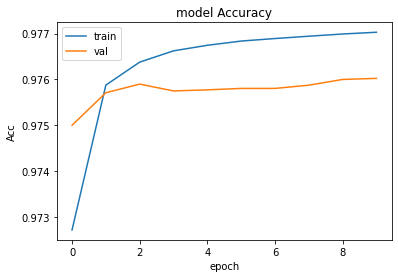

In [125]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [126]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [129]:
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61266
         1.0       0.60      0.61      0.60      4041

    accuracy                           0.95     65307
   macro avg       0.79      0.79      0.79     65307
weighted avg       0.95      0.95      0.95     65307



# Задание 2
2) В одной из задач используйте сразу две предобученные эмбединг модели (можно фастекст и ворд2век, а можно просто 2 фастекста с разными параметрами) в одной нейронке (имеется в виду предобученные до обучения нейронки, т.е вы можете сами обучить фастекст/ворд2век и не искать готовые модели в интернете). Попробуйте усреднять эмбединги и конкатенировать (общие эмбединги потом в один вектор собирайте любым способом - например, тем который оказался лучше в первой задаче).

Попробую объединить Word2Vec и FastText эмбеддинги

In [130]:
texts = train_dataset.question_text.apply(preprocess).tolist()

In [136]:
%%time
ft = gensim.models.FastText(texts, size=100, iter=5)
w2v = gensim.models.Word2Vec(texts, size=100, iter=10)

CPU times: user 17min 2s, sys: 5.9 s, total: 17min 8s
Wall time: 9min 14s


In [144]:
weights_ft = np.zeros((len(word2id), 100))
weights_w2v = np.zeros((len(word2id), 100))
unk_vector = np.random.uniform(low=-1, high=1, size=(100,))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue   
    try:
        weights_ft[i] = ft.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights[i] = ft.wv['опрагпллирао']

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue   
    try:
        weights_w2v[i] = w2v.wv[word]
    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        weights[i] = unk_vector

## Усреднение 

In [152]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, 
                 embeddings_ft, embeddings_w2v, output_dim):
        
        super().__init__()          
        self.ft_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.w2v_embedding = nn.Embedding(vocab_size, embedding_dim)

        self.ft_embedding.from_pretrained(torch.tensor(embeddings_ft), freeze=True)
        self.w2v_embedding.from_pretrained(torch.tensor(embeddings_w2v), freeze=True)

        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded_ft = self.ft_embedding(text)   
        embedded_ft = torch.mean(embedded_ft, dim=1)

        embedded_w2v = self.w2v_embedding(text)   
        embedded_w2v = torch.mean(embedded_w2v, dim=1)

        embedded_mean = (embedded_w2v + embedded_ft) / 2
        
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [153]:
model = Clf(len(word2id), embedding_dim=100,
            embeddings_ft=weights_ft, embeddings_w2v=weights_w2v, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [154]:
accs = []
accs_eval = []
for i in range(10):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.2267019248849995; Accuracy: 0.9387160598098098
Loss: 0.2048865467824299; Accuracy: 0.9391590326413206
Loss: 0.18831415622482384; Accuracy: 0.9407471761420474
Loss: 0.17712062666861975; Accuracy: 0.9422775615778944
1
Loss: 0.13521334117239303; Accuracy: 0.9500555242742743
Loss: 0.13338548804504266; Accuracy: 0.9501723518009004
Loss: 0.13205057719462154; Accuracy: 0.9503102596698899
Loss: 0.13080027853549794; Accuracy: 0.9505999546761691
2
Loss: 0.12542944671483608; Accuracy: 0.9530585272772772
Loss: 0.12478182604979014; Accuracy: 0.9527693534267133
Loss: 0.12424859383571105; Accuracy: 0.9526873541180394
Loss: 0.12366669406687268; Accuracy: 0.9528114450487621
3
Loss: 0.12146964417891698; Accuracy: 0.9544309934934935
Loss: 0.1211549250400621; Accuracy: 0.9540082541270636
Loss: 0.12085636359462144; Accuracy: 0.9538856702234078
Loss: 0.1204545160699156; Accuracy: 0.9539367263690923
4
Loss: 0.11936344272709705; Accuracy: 0.9552521271271271
Loss: 0.11920008338007586; Accuracy: 0.954

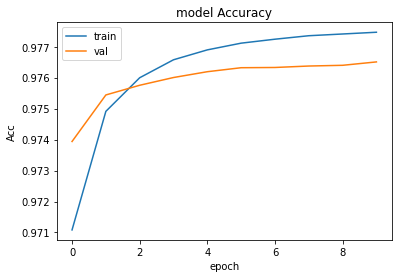

In [155]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [156]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [163]:
print(classification_report(targets, (np.array(preds) > 0.25).astype(int)))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     61266
         1.0       0.58      0.65      0.61      4041

    accuracy                           0.95     65307
   macro avg       0.78      0.81      0.79     65307
weighted avg       0.95      0.95      0.95     65307



## Конкатенация

In [167]:
class Clf(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, 
                 embeddings_ft, embeddings_w2v, output_dim):
        
        super().__init__()
        self.flatten = nn.Flatten()          
        self.ft_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.w2v_embedding = nn.Embedding(vocab_size, embedding_dim)

        self.ft_embedding.from_pretrained(torch.tensor(embeddings_ft), freeze=True)
        self.w2v_embedding.from_pretrained(torch.tensor(embeddings_w2v), freeze=True)

        self.fc = nn.Linear(embedding_dim, output_dim)
        self.act = nn.Sigmoid() 
        
    def forward(self, text):
        
        embedded_ft = self.ft_embedding(text)   
        embedded_ft = torch.mean(embedded_ft, dim=1)

        embedded_w2v = self.w2v_embedding(text)   
        embedded_w2v = torch.mean(embedded_w2v, dim=1)

        hidden_ft = self.flatten(embedded_ft)
        hidden_w2v = self.flatten(embedded_w2v)

        embedded_mean = (hidden_w2v + hidden_ft) / 2
        
        dense_outputs = self.fc(embedded_mean)
        outputs=self.act(dense_outputs)
        
        return outputs

In [183]:
model = Clf(len(word2id), embedding_dim=100,
            embeddings_ft=weights_ft, embeddings_w2v=weights_w2v, output_dim=1)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss() 

model = model.to(device)
criterion = criterion.to(device)

In [184]:
accs = []
accs_eval = []
for i in range(3):
    print(i)
    accs.append(train(model, training_generator, optimizer, criterion))
    accs_eval.append(evaluate(model, valid_generator, criterion))

0
Loss: 0.2260284845431049; Accuracy: 0.9381021646646647
Loss: 0.202374991817794; Accuracy: 0.9390886849674838
Loss: 0.18619842675029138; Accuracy: 0.94079015921974
Loss: 0.17533545071693712; Accuracy: 0.9424094304826206
1
Loss: 0.13433486784811136; Accuracy: 0.9501767392392393
Loss: 0.1325978711098358; Accuracy: 0.9503423586793397
Loss: 0.13132802617126563; Accuracy: 0.9505264775758586
Loss: 0.13017457765817017; Accuracy: 0.950816805763941
2
Loss: 0.12494571863098426; Accuracy: 0.9530858983983984
Loss: 0.12431490360728915; Accuracy: 0.9528592421210605
Loss: 0.12381940828925095; Accuracy: 0.9528475637712571
Loss: 0.12329769636164102; Accuracy: 0.9529755485746436


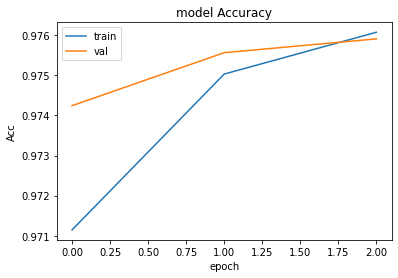

In [185]:
plt.plot(np.sqrt(accs))
plt.plot(np.sqrt(accs_eval))
plt.title('model Accuracy')
plt.ylabel('Acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [186]:
preds = []
targets = []
for texts, ys in valid_generator:
    preds += model(texts.to(device)).squeeze().detach().to('cpu').numpy().tolist()
    targets += ys.numpy().tolist()

In [201]:
print(classification_report(targets, (np.array(preds) > 0.3).astype(int)))

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97     61266
         1.0       0.61      0.59      0.60      4041

    accuracy                           0.95     65307
   macro avg       0.79      0.78      0.79     65307
weighted avg       0.95      0.95      0.95     65307

